## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.0


In [150]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors,datasets
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
from sklearn.linear_model import LogisticRegression

# load in the data
train_data = pd.read_csv('/Users/tewodros/Downloads/Starbucks-promotion-experiment/code/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [53]:
# check the shape
train_data.shape

(84534, 10)

In [54]:
# check any missing and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


Note :- Fortunately, data integrity is perfect. All non-null, and no mixed types.

Distribuition of Not purchase(0) and Purchase(1): 
0    83494
1     1040
Name: purchase, dtype: int64

Not purchase 98.77 % of the dataset
Purchase 1.23 % of the dataset


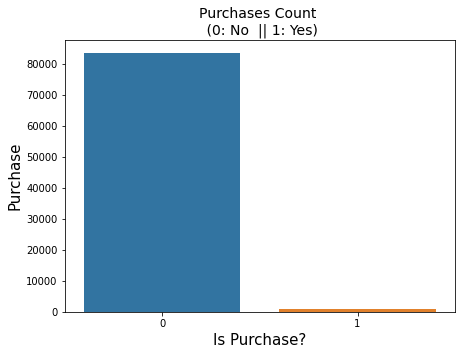

In [55]:
#Lets start looking the difference by Normal and Fraud transactions
print("Distribuition of Not purchase(0) and Purchase(1): ")
print(train_data["purchase"].value_counts())
print('')

# The classes are heavily skewed we need to solve this issue later.
print('Not purchase', round(train_data['purchase'].value_counts()[0]/len(train_data) * 100,2), '% of the dataset')
print('Purchase', round(train_data['purchase'].value_counts()[1]/len(train_data) * 100,2), '% of the dataset')

plt.figure(figsize=(7,5))
sns.countplot(train_data['purchase'])
plt.title('Purchases Count \n (0: No  || 1: Yes)', fontsize=14)
plt.xlabel("Is Purchase?", fontsize=15)
plt.ylabel("Purchase", fontsize=15)
plt.show()

To see the count of unique values for each purchase types. The target datasets are imbalanced. Apply SMOTE technques 

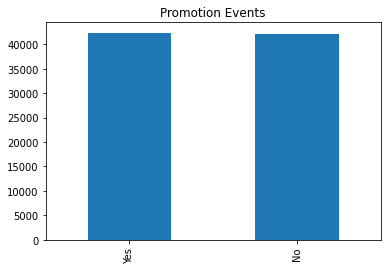

In [56]:
s = train_data['Promotion'].value_counts().plot(kind = 'bar')
plt.title('Promotion Events')
plt.show()

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'purchase'}>,
        <AxesSubplot:title={'center':'V1'}>],
       [<AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>],
       [<AxesSubplot:title={'center':'V5'}>,
        <AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>]], dtype=object)

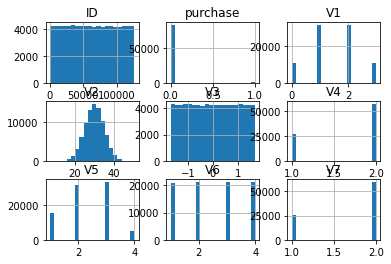

In [57]:
# Histogram distributin 
train_data.hist(bins = 20)

In [58]:
# Summary Statistics
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,84534.0,62970.972413,36418.440539,1.000000,31467.250000,62827.500000,94438.750000,126184.000000
purchase,84534.0,0.012303,0.110234,0.000000,0.000000,0.000000,0.000000,1.000000
V1,84534.0,1.500662,0.868234,0.000000,1.000000,2.000000,2.000000,3.000000
V2,84534.0,29.973600,5.010626,7.104007,26.591501,29.979744,33.344593,50.375913
V3,84534.0,0.000190,1.000485,-1.684550,-0.905350,-0.039572,0.826206,1.691984
V4,84534.0,1.679608,0.466630,1.000000,1.000000,2.000000,2.000000,2.000000
V5,84534.0,2.327643,0.841167,1.000000,2.000000,2.000000,3.000000,4.000000
V6,84534.0,2.502898,1.117349,1.000000,2.000000,3.000000,4.000000,4.000000
V7,84534.0,1.701694,0.457517,1.000000,1.000000,2.000000,2.000000,2.000000


<AxesSubplot:>

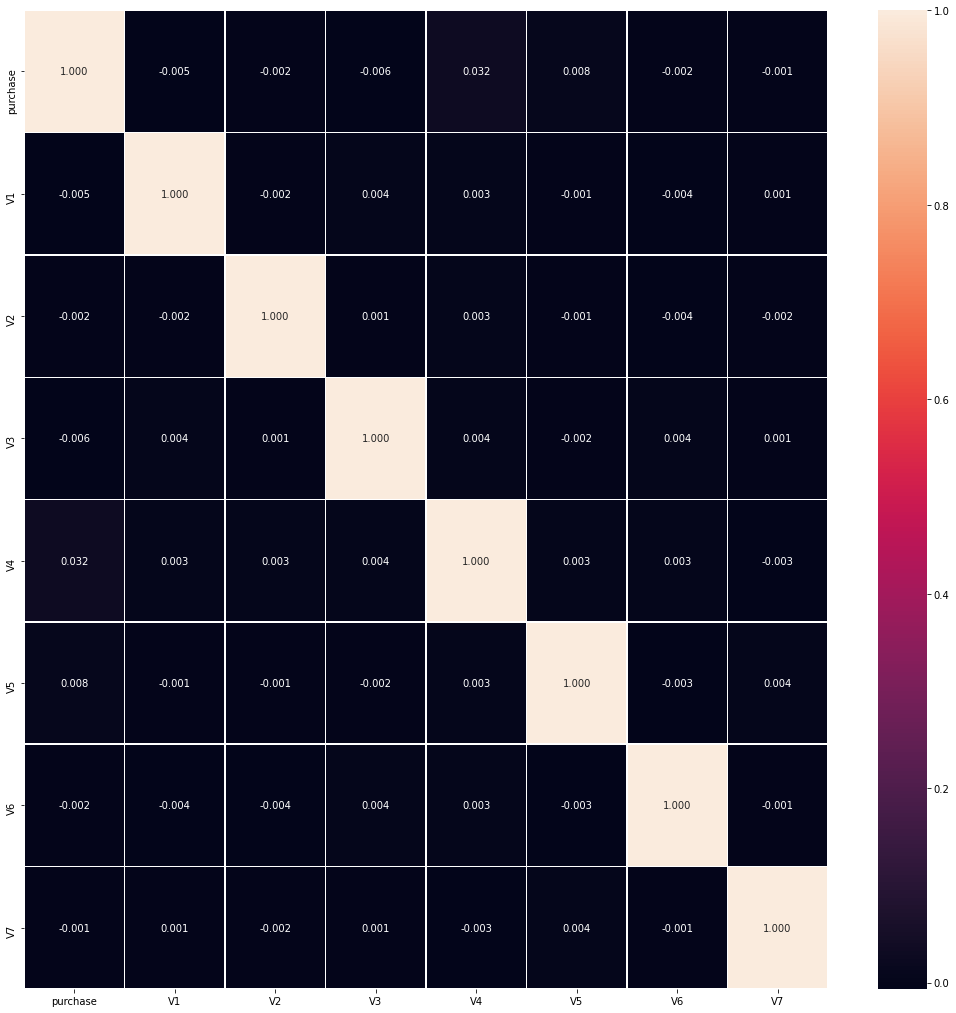

In [134]:
# check Correlation 
df = train_data.drop(['ID', 'Promotion'] , axis = 1)
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)

In [60]:
# Split dataset in experimenta group and control group
promotion_group = train_data[train_data['Promotion']== 'Yes']
n_promotion = promotion_group.shape[0]
print(promotion_group.shape)
print(n_promotion)

control_group = train_data[train_data['Promotion'] == 'No']
n_control = control_group.shape[0]
print(control_group.shape)
print(n_control)


(42364, 10)
42364
(42170, 10)
42170


In [61]:
# Calculate the probability for purchase in experiment and control group

# define model
model = DecisionTreeClassifier()

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv =cv, n_jobs=-1 )
print('Mean ROC AUC: %.3f' % np.mean(scores))# define model
model = DecisionTreeClassifier()

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv =cv, n_jobs=-1 )
print('Mean ROC AUC: %.3f' % np.mean(scores))# define model
model = DecisionTreeClassifier()

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv =cv, n_jobs=-1 )
print('Mean ROC AUC: %.3f' % np.mean(scores))# ####SSSpurchasers_promotion = promotion_group.groupby('purchase').size()[1]
print(p_promotion)
print(purchasers_promotion)

p_control = list(control_group.groupby('purchase').size())[1] / n_control
purchaser_control = control_group.groupby('purchase').size()[1]
print(p_control)
print(purchaser_control)      

0.017019167217448776
721
0.007564619397676073
319


In [62]:
#Compute IRR
IRR = p_promotion - p_control
IRR

0.009454547819772702

In [63]:
# Compute NIR
NIR = (10 * purchasers_promotion - 0.15 * n_promotion) - 10 * purchaser_control
print(NIR)

-2334.5999999999995


In [64]:
# Base line prediction of purchase using default setting on the data without modification
y = train_data['purchase']
X = train_data.iloc[:,3:]

In [135]:
# split into train / test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Class balance in test group
print("TEST GROUP")
print('Size:',y_test.count())
print("Purchase percentage:",
      y_test.value_counts()[1]/y_test.count())
print("Not Purchase percentage:",
      y_test.value_counts()[0]/y_test.count())

# Class balance in train group
print("\nTRAIN GROUP")
print('Size:',y_train.count())
print("Purchase percentage:",
      y_train.value_counts()[1]/y_train.count())
print("Not Purchase percentage:",
      y_train.value_counts()[0]/y_train.count())

TEST GROUP
Size: 16907
Purchase percentage: 0.012302596557638847
Not Purchase percentage: 0.9876974034423611

TRAIN GROUP
Size: 67627
Purchase percentage: 0.012302778476052463
Not Purchase percentage: 0.9876972215239476


## Baseline Algorithms

let start without any modification for feature variables

TRAIN GROUP

Cross-validation accuracy scores: [0.98766801 0.98771183 0.98771183]
Mean score: 0.9876972219558714

TEST GROUP

Accuracy score: 0.9876974034423611

Classification report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16699
           1       0.00      0.00      0.00       208

    accuracy                           0.99     16907
   macro avg       0.49      0.50      0.50     16907
weighted avg       0.98      0.99      0.98     16907



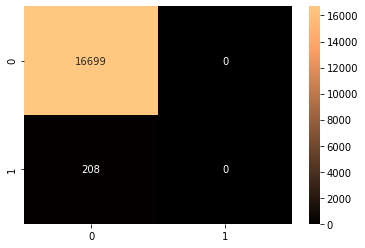

In [66]:
# Invoke Classifier
clf = LogisticRegression()

# Cross-validate on the train data
train_cv = cross_val_score(X=X_train,y=y_train,estimator=clf,cv=3)
print("TRAIN GROUP")
print("\nCross-validation accuracy scores:",train_cv)
print("Mean score:",train_cv.mean())

# Now predict on the test group
print("\nTEST GROUP")
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("\nAccuracy score:",clf.score(X_test,y_test))

# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

The confusion matrix and classification reports reveal that the high scores are merely a reflection of the class imbalance. Since we're using a generalized scoring method, accuracy reflects the recall of both purchase and not purchase. However, since purchase are so few,(0.0012%) their poor recall (0.00%) isn't reflected in the overall accuracy score.

In [29]:
# Apply Standard Scaling
col=train_data.columns
features = col.tolist() 
feature  = features[3:]
sc = StandardScaler()
x = sc.fit_transform(X)
pd.DataFrame(x,columns=feature).head()

,V1,V2,V3,V4,V5,V6,V7
0,0.575122,0.093785,-1.164716,-1.456427,-1.578345,0.444897,0.652014
1,1.726893,0.436226,-0.645498,0.686612,0.799319,-0.450084,0.652014
2,0.575122,0.091418,0.133329,-1.456427,-1.578345,1.339877,0.652014
3,-1.728419,-0.675506,-0.212816,0.686612,-1.578345,1.339877,0.652014
4,1.726893,-0.385038,-0.385889,-1.456427,-1.578345,-0.450084,0.652014


In [87]:
# Apply PCA with Two Components
pca = PCA(n_components = 2)
components = pca.fit_transform(x)
principalDf = pd.DataFrame(data = components, columns=['pca 1', 'pc2'])
principalDf.head()

,pca 1,pc2
0,0.850854,1.133411
1,0.264745,-1.862808
2,-0.323732,1.358050
3,-0.669904,2.059182
4,0.635032,0.068077


In [33]:
finalDf = pd.concat([principalDf, train_data[['purchase']]], axis = 1)
finalDf.head()

,pca 1,pc2,purchase
0,0.850854,1.133411,0
1,0.264745,-1.862808,0
2,-0.323732,1.358050,0
3,-0.669904,2.059182,0
4,0.635032,0.068077,0


Note : Applying Standardscaler and PCA are not make an improvementa for mean scores. So ignore to use. just apply for helping to plot

In [38]:
# Plot helper function
def draw_plot(X,y , label):
    for l in np.unique(y):
        plt.scatter(
            X[y == l, 0],
            X[y== l, 1],
            label = l
        )
    plt.title(label)
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.legend()
    plt.show()

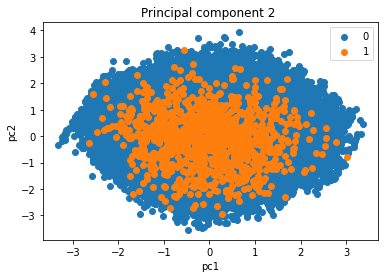

In [40]:
#plot raw PCA
draw_plot(components, y, 'Principal component 2 ')

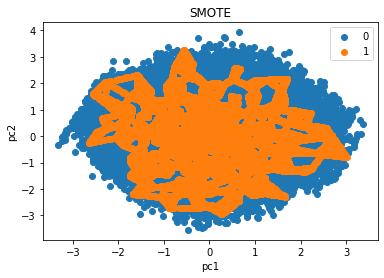

In [74]:
# Next, we can oversample the minority class using SMOTE and plot the transformed dataset.

# Define SMOTE model and specifiy minority class for oversample

smote = SMOTE(  k_neighbors= 4)

# Fit data
X_smote, y_smote = smote.fit_resample(components, y)

# plot
draw_plot(X_smote, y_smote, 'SMOTE')

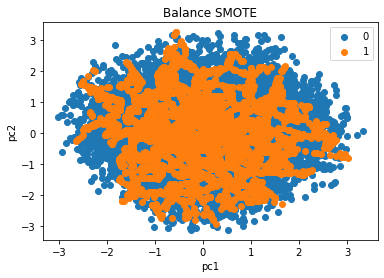

In [105]:
#define pipeline the minority class 10% and then the majority
#  class random undersampling to reduce  50%

over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy= 0.5)

pipeline = Pipeline(steps = [('o', over), ('u', under)])

X_pip, Y_pip = pipeline.fit_resample(components,y)
# plot
draw_plot(X_pip, Y_pip, 'Balance SMOTE')

# SMOTE for Classification

In [132]:
model = XGBClassifier(random_state= 42)
scores = cross_val_score(model, X, y, scoring= 'roc_auc', n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.562


In [133]:
# Define model
model = XGBClassifier(random_state= 42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring= 'roc_auc',cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.564


# Try the same model and evaluation use SMOTE 

In [129]:
pipeline = Pipeline(steps= [
    ('over', SMOTE(random_state= 42)), 
    ('model', XGBClassifier())
])

# Evaulate pipeline
scores = cross_val_score(pipeline,X,y, scoring='roc_auc', cv=cv,n_jobs=-1)
print('Mean ROC AUC: %.3f' %np.mean(scores))

Mean ROC AUC: 0.539


In [130]:
# Define pipeline
model = XGBClassifier()
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy= 0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)
scores = cross_val_score(pipeline,X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.556


In [131]:
k_values = [5,6,7,8,9,10,11]

for k in k_values:
    # define pipeline
	model = XGBClassifier()
	over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.5)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	scores = cross_val_score(pipeline,X,y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = np.mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=5, Mean ROC AUC: 0.554
> k=6, Mean ROC AUC: 0.550
> k=7, Mean ROC AUC: 0.550
> k=8, Mean ROC AUC: 0.554
> k=9, Mean ROC AUC: 0.548
> k=10, Mean ROC AUC: 0.554
> k=11, Mean ROC AUC: 0.551


In [145]:
performance = pd.DataFrame(columns= ['Train_Recall','Test_Recall','Test_Specificity'])


 ---------------------------------------- 
 SVC 
 ----------------------------------------
Train Group

Cross-validation recall scores [0.9676259  0.92779783 0.9566787 ]

Test Group

Recall: 0.0

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Train Group

Cross-validation recall scores [0.0647482  0.04693141 0.06137184]

Test Group

Recall: 0.0

 ---------------------------------------- 
 DecisionTreeClassifier 
 ----------------------------------------
Train Group

Cross-validation recall scores [0.11870504 0.14440433 0.11552347]

Test Group

Recall: 0.028846153846153848

 ---------------------------------------- 
 KNeighborsClassifier 
 ----------------------------------------
Train Group

Cross-validation recall scores [0.24100719 0.20577617 0.25631769]

Test Group

Recall: 0.0


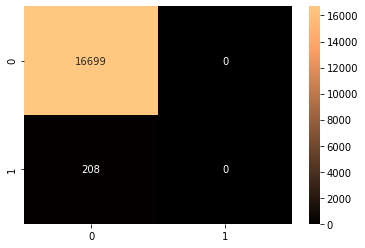

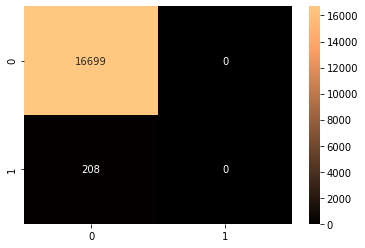

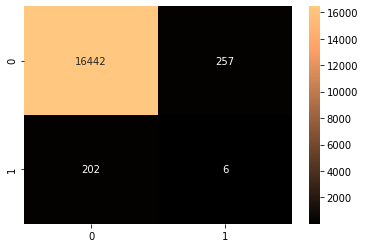

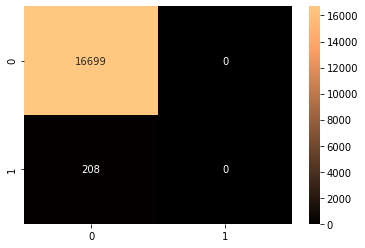

In [146]:
# load simple classifiers
classifiers = [SVC(max_iter = 1000),LogisticRegression(),
               DecisionTreeClassifier(), KNeighborsClassifier()]
over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Get a classification report from each algorithm

for clf in classifiers:
    steps = [('over', over), ('under', under), ('model', clf)]
    pipeline = Pipeline(steps=steps)
    # Heading
    print('\n', '-'*40, '\n', clf.__class__.__name__,'\n','-'*40)

    # Cross-validate on the train data 
    print("Train Group")
    train_cv = cross_val_score(X= X_train,y= y_train, estimator=pipeline,
    scoring= recall,cv = 3)
    print('\nCross-validation recall scores', train_cv)

    # Now predict on the test group
    print("\nTest Group")
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print('\nRecall:', recall_score(y_test, y_pred))

    #Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    # Store results
    performance.loc[clf.__class__.__name__+'_default',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]




In [147]:
performance

,Train_Recall,Test_Recall,Test_Specificity
SVC_default,0.950701,0.000000,1.00000
LogisticRegression_default,0.057684,0.000000,1.00000
DecisionTreeClassifier_default,0.126211,0.028846,0.98461
KNeighborsClassifier_default,0.234367,0.000000,1.00000


In [ ]:
# Now let'do a GridSearchCV to find the best parameters for DecisionTreeClassifier


 ---------------------------------------- 
 DecisionTreeClassifier 
 ----------------------------------------
Best parameters: 

 {'model__criterion': 'gini', 'model__max_depth': 3, 'model__max_features': 1, 'model__min_samples_leaf': 1, 'model__min_samples_split': 3} 

TRAIN GROUP

Cross-validation recall scores: [0.98561151 0.98555957 1.        ]
Mean recall score: 0.9903903591927902

TEST GROUP

Recall: 0.9951923076923077
              precision    recall  f1-score   support

           0       0.99      0.00      0.01     16699
           1       0.01      1.00      0.02       208

    accuracy                           0.02     16907
   macro avg       0.50      0.50      0.02     16907
weighted avg       0.97      0.02      0.01     16907



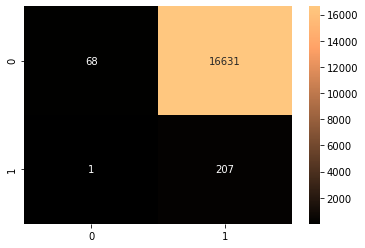

In [208]:
# Parameters to optimize
params = [ {'model__max_depth': np.arange(3, 10),
  'model__max_features':[1,3,10],
  'model__min_samples_split':[1,3,10],
  'model__min_samples_leaf': [1,3,10],
  'model__criterion':['gini', 'entropy']
  }   
]
over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

clf = DecisionTreeClassifier(class_weight = {0:0.1,1:1 },random_state=0)

steps = [('over', over), ('under', under), ('model', clf)]
pipe = Pipeline(steps=steps)
# Load GridSearchCV
search = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    n_jobs=-1,
    scoring=recall,
    refit = True
)

# Train search object
search.fit(X_train, y_train)

# Heading
print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

# Extract best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, 
                           estimator=best, scoring=recall,cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())

# Now predict on the test group
print("\nTEST GROUP")
y_pred = best.fit(X_train, y_train).predict(X_test)
print("\nRecall:",recall_score(y_test,y_pred))

# Get classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()
    
# Store results
performance.loc[clf.__class__.__name__+'_search',
                ['Train_Recall','Test_Recall','Test_Specificity']] = [
    train_cv.mean(),
    recall_score(y_test,y_pred),
    conf_matrix[0,0]/conf_matrix[0,:].sum()
]

In [210]:
# Make a scoring function that improve specificity while identifying all purchase
def recall_optim(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred)
    # recall will be worth a greater value than a specificity 
    rec = recall_score(y_test, y_pred)*0.8
    spe = conf_matrix[0,0]/ conf_matrix[0,:].sum()*0.2

    # Imperfect recalls will lose a penality
    if rec < 0.8:
        rec -= 0.2
    
    return rec + spe

# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)


In [211]:
scores = []
for rec, spe in performance[['Test_Recall','Test_Specificity']].values:
    rec = rec * 0.8
    spe = spe * 0.2
    if rec < 0.8:
        rec -= 0.20
    scores.append(rec + spe)
performance['Optimize'] = scores
display(performance)

,Train_Recall,Test_Recall,Test_Specificity,Optimize
SVC_default,0.950701,0.000000,1.000000,0.000000
LogisticRegression_default,0.057684,0.000000,1.000000,0.000000
DecisionTreeClassifier_default,0.126211,0.028846,0.984610,0.019999
KNeighborsClassifier_default,0.234367,0.000000,1.000000,0.000000
DecisionTreeClassifier_search,0.990390,0.995192,0.004072,0.596968


In [231]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    # Select X and y from training data
    X = train_data.drop(['purchase', 'Promotion', 'ID'], axis = 1)
    y = train_data['purchase']


    # Apply SMOTE due to imbalance datasets and choose model
    # Parameters to optimize
    params = [ {'model__max_depth': np.arange(3, 10),
                'model__max_features':[1,3,10],
                'model__min_samples_split':[1,3,10],
                'model__min_samples_leaf': [1,3,10],
                'model__criterion':['gini', 'entropy']
                } ]

    over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)

    clf = DecisionTreeClassifier(class_weight = {0:0.1,1:1 },random_state=0)

    steps = [('over', over), ('under', under), ('model', clf)]
    pipe = Pipeline(steps=steps)
    # Load GridSearchCV
    search = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    n_jobs=-1,
    scoring=recall,
    refit = True)

    #Training 
    print('clf is fitting...')
    search.fit(X, y)

    # Extract best estimator
    best = search.best_estimator_
    print('Best parameters: \n\n',search.best_params_,'\n')
    # Cross-validate on the train data
    print("TRAIN GROUP")
    train_cv = cross_val_score(X=X_train, y=y_train, 
    estimator=best, scoring=recall,cv=3)

    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())
    #Predicting 
    print('Clf is now prediciting...')
    purchase =  best.fit(X,y).predict(df)
    
    promotion = pd.Series(purchase).replace({0:'No', 1:'Yes'})

    print('Computations are ready')
    
    return promotion

In [232]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

clf is fitting...
Best parameters: 

 {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__max_features': 1, 'model__min_samples_leaf': 10, 'model__min_samples_split': 3} 

TRAIN GROUP

Cross-validation recall scores: [0.98920863 1.         0.99277978]
Mean recall score: 0.993996138829009
Clf is now prediciting...
Computations are ready
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1118.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009641961221824546, -1118.9)